In [1]:
%matplotlib inline

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN

import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Echonest audio features - IMBALANCED LEARNING
## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- bin-genre_decision-tree_KNN  (section 2)

Sinci in our previous analysis we found out that both Decision Tree and KNN had higher performances with PCA, we decided to improve our results starting from those classifiers.

In [2]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

__________________________________
# 2 Binary genre - ROCK & JAZZ
__________________________________
## a) Import dataset

In [3]:
binclass_dataset = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_outlierfree.csv')
binclass_dataset.set_index('track_id', inplace=True)
#binclass_dataset.drop('listens',axis=1, inplace=True)
#binclass_dataset.drop('comments',axis=1, inplace=True)
#binclass_dataset = binclass_dataset[binclass_dataset['genre_top'].isin(['Rock','Jazz'])]
binclass_dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,duration,bit_rate,genre_top
track_id,,,,,,,,,,,
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,0.650452,120.790,326,256,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,0.682397,135.468,354,256,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,0.917613,120.218,232,256,Jazz
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,0.034018,90.241,405,256,Rock
154,0.970135,0.352946,0.023852,0.957113,0.113261,0.032177,0.035632,53.758,319,256,Rock


In [4]:
print(binclass_dataset.shape)

(4095, 11)


### Preprocessing

[]

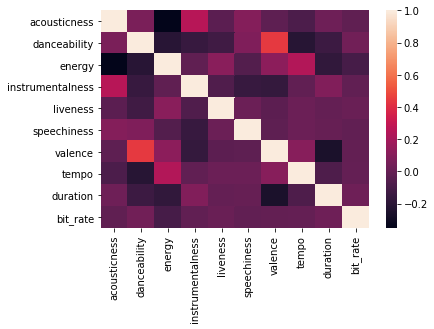

In [5]:
corr = binclass_dataset.corr()
sns.heatmap(corr)
plt.plot()

The highest correlation is the one between valence and danceability ***approximately 0.5***<br>
This makes sense. If a song can be danced it means it is an happy song.
Also the correlation between energy and tempo is easily explainable.

In [6]:
print('Class distribution before balancing')
pd.concat(
    [binclass_dataset.genre_top.value_counts(),
                round(binclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing


,counts,percentage (%)
Rock,3863,94.33
Jazz,232,5.67


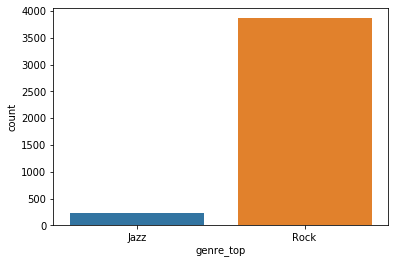

In [7]:
sns.countplot(x='genre_top', data=binclass_dataset[['genre_top']] )



In [8]:
# Data preprocessing
le = preprocessing.LabelEncoder()
binclass_dataset['genre_top'] = le.fit_transform(binclass_dataset['genre_top'])
print('Legend:\n0: Jazz\n1: Rock')
# Define the labels
labels = binclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels[['genre_top']]

Legend:
0: Jazz
1: Rock


In [9]:
# remove labels from dataset
binclass_dataset.drop('genre_top', axis=1, inplace=True)

In [10]:
labels.head()

,genre_top
0,0
1,0
2,0
3,1
4,1


In [11]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(binclass_dataset)

## b) Compute PCA and plot distribution in 2D

In [12]:
# compute PCA using optimal number of components: 8 ( discovered in the notebook mentioned above)
pca = PCA(8,random_state=42)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)

In [13]:
# split data in development and internal test

#with normalization
X_pca, X_test_pca, y_pca, y_test_pca = train_test_split(X_pca, labels, test_size=0.30, random_state=42, stratify=labels)

# without normalization
X, X_test, y, y_test = train_test_split(binclass_dataset, labels, test_size=0.30, random_state=42, stratify=labels) 



In [14]:
# normalize data for KNN
scaler.fit(X)
X_norm=scaler.transform(X)
X_test_norm = scaler.transform(X_test)

In [15]:
# development set shape
X.shape, y.shape

((2866, 10), (2866, 1))

In [16]:
# internal test shape
X_test.shape, y_test.shape

((1229, 10), (1229, 1))

In [17]:
print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

Class distribution before balancing after splitting in train test


,counts,percentage (%)
genre_top,,
1,2704,94.35
0,162,5.65


In [18]:
# function for plotting data in 2D with PCA
def pca_2D(data, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = data[:,0]
    df['pca2'] = data[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        palette={'Jazz':'darkblue','Rock':'coral'},
        data=df,
        legend="full",
        alpha=0.5
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

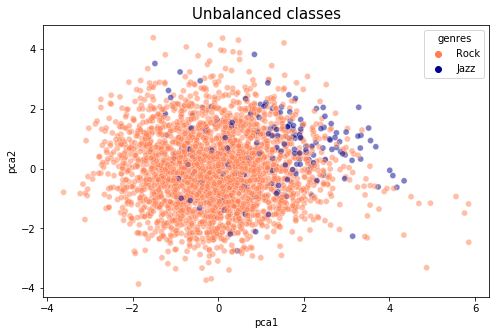

In [19]:
pca_2D(X_pca, y_pca,'Unbalanced classes')

## c) Imbalanced learning:
#### c.1) Undersampling - Random

In [20]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under_pca, y_under_pca = under_sample.fit_resample(X_pca,y_pca)
X_under, y_under = under_sample.fit_resample(X,y)   # for decision tree - because it doesn't need normalization
X_norm_under, y_norm_under = under_sample.fit_resample(X_norm,y)   # for KNN - normalized data

In [21]:
print('Legend:\n0: Jazz\n1: Rock\nClass distribution after Random Undersampling:')
y_under.value_counts()

Legend:
0: Jazz
1: Rock
Class distribution after Random Undersampling:


genre_top
0            162
1            162
dtype: int64

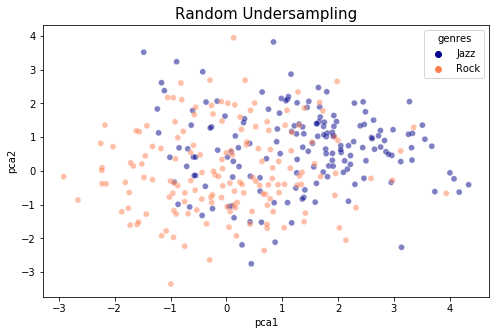

In [22]:
pca_2D(X_under_pca,y_under_pca,'Random Undersampling')

#### c.2) Condensed Nearest Neighbor (CNN)

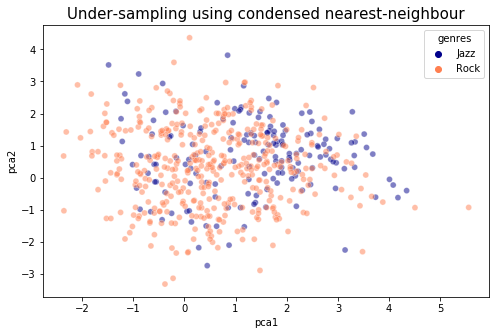

In [23]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn_pca, y_cnn_pca = cnn.fit_resample(X_pca, y_pca)
X_cnn, y_cnn = cnn.fit_resample(X, y)
X_norm_cnn_, y_norm_cnn = cnn.fit_resample(X_norm, y)


#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn_pca,y_cnn_pca,'Under-sampling using condensed nearest-neighbour')

#### c.3) Tomek's Link

In [24]:
#help(TomekLinks)

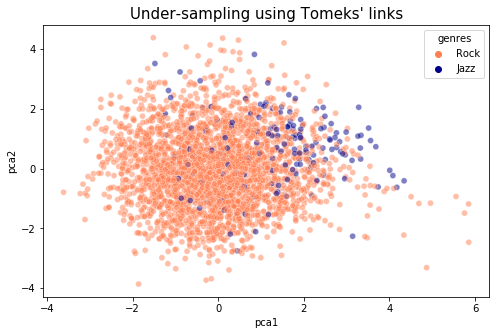

In [25]:
tomeks = TomekLinks(sampling_strategy='not minority')
X_tomek, y_tomek = tomeks.fit_resample(X, y)
X_tomek_pca, y_tomek_pca = tomeks.fit_resample(X_pca, y_pca)
X_norm_tomek, y_norm_tomek = tomeks.fit_resample(X_norm, y)


pca_2D(X_tomek_pca, y_tomek_pca, 'Under-sampling using Tomeks\' links')

In [26]:
y_tomek.value_counts()

genre_top
1            2621
0             162
dtype: int64

#### c.4) Oversampling - Random

In [27]:
over_sample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = over_sample.fit_resample(X, y)
X_over_pca, y_over_pca = over_sample.fit_resample(X_pca, y_pca)
X_norm_over, y_norm_over = over_sample.fit_resample(X_norm, y)


In [28]:
X_over.shape, y_over.shape

((5408, 10), (5408, 1))

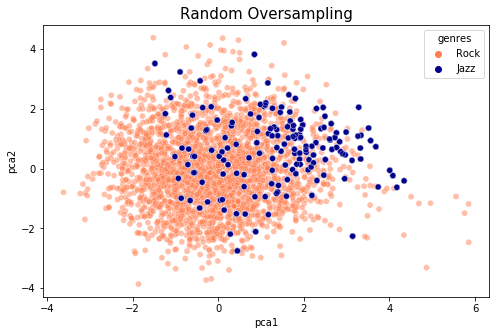

In [29]:
pca_2D(X_over_pca, y_over_pca, 'Random Oversampling')

#### c.5) SMOTE

In [30]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote_pca, y_smote_pca = smote_over.fit_resample(X_pca, y_pca)
X_norm_smote, y_norm_smote = smote_over.fit_resample(X_norm, y)

X_smote.shape, y_smote.shape

((5408, 10), (5408, 1))

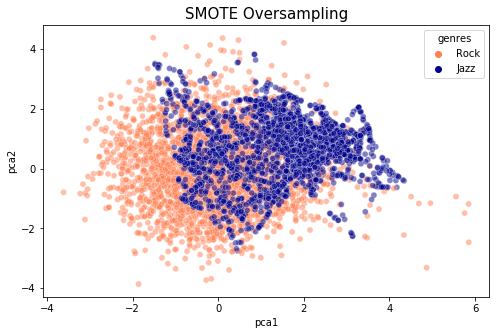

In [31]:
pca_2D(X_smote_pca, y_smote_pca, 'SMOTE Oversampling')

#### K-Means SMOTE

In [32]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=100, k_neighbors=6,cluster_balance_threshold=0.)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)
X_norm_ksmote, y_norm_ksmote = ksmote.fit_resample(X_norm, y)

X_ksmote_pca, y_ksmote_pca = ksmote.fit_resample(X_pca, y_pca)

In [33]:
y_ksmote.value_counts()

genre_top
0            2704
1            2704
dtype: int64

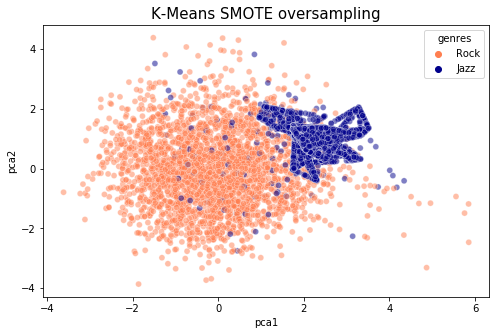

In [34]:
pca_2D(X_ksmote_pca, y_ksmote_pca, "K-Means SMOTE oversampling")

#### c.6) ADASYN

In [35]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
X_adasyn_pca, y_adasyn_pca = adasyn.fit_resample(X_pca, y_pca)
X_norm_adasyn, y_norm_adasyn = adasyn.fit_resample(X_norm, y)


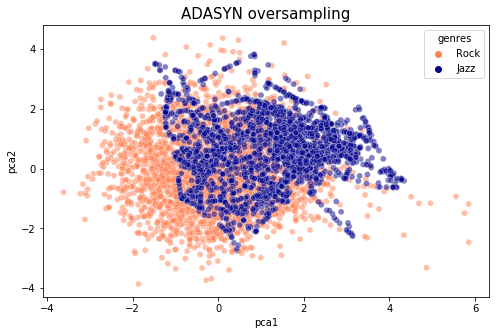

In [36]:
pca_2D(X_adasyn_pca, y_adasyn_pca, "ADASYN oversampling")

## d) Decision tree

### Random Search  - Decision Tree (full dim)

In [56]:
from sklearn.model_selection import RandomizedSearchCV

In [57]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]
params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(5,40)],
         "min_samples_leaf": [x for x in range(10,40)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=200, random_state=42,
                             verbose=True, return_train_score=True, scoring='f1_macro', n_jobs=-1)
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   13.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******unbalanced*******
{'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 8, 'criterion': 'gini'}
accuracy validation: 0.6529840166611006
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******undersampling*******
{'min_samples_split': 16, 'min_samples_leaf': 17, 'max_depth': 5, 'criterion': 'entropy'}
accuracy validation: 0.7610485729026356
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******condensed NN*******
{'min_samples_split': 7, 'min_samples_leaf': 11, 'max_depth': 7, 'criterion': 'gini'}
accuracy validation: 0.724550467051621
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******Tomek links*******
{'min_samples_split': 30, 'min_samples_leaf': 14, 'max_depth': 8, 'criterion': 'gini'}
accuracy validation: 0.6346428279148585
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******oversampling*******
{'min_samples_split': 12, 'min_samples_leaf': 10, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.9350501891370733
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******SMOTE*******
{'min_samples_split': 12, 'min_samples_leaf': 10, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.8984250363206681
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******K-means SMOTE*******
{'min_samples_split': 38, 'min_samples_leaf': 14, 'max_depth': 8, 'criterion': 'entropy'}
accuracy validation: 0.9502614753389841
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.5s


*******ADASYN*******
{'min_samples_split': 23, 'min_samples_leaf': 18, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.8793038926790395


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.8s finished


### d.2) Retrain Models : Unbalanced vs Balanced

In [37]:
data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    
    'unbalanced':DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 15, min_samples_split=10),

    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=5,
                                        min_samples_leaf= 17, min_samples_split=16),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'gini',max_depth=7,
                                        min_samples_leaf= 11, min_samples_split=7),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 14, min_samples_split=30),
    
    "oversampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 10, min_samples_split=12),
    
    "SMOTE":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 10, min_samples_split=12),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 14, min_samples_split=38),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 18, min_samples_split=23)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    y_score = dt.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9365337672904801
F1-score [0.27777778 0.96680851]

Recall [0.21428571 0.98015531]
Precision [0.39473684 0.95382032]
              precision    recall  f1-score   support

           0       0.39      0.21      0.28        70
           1       0.95      0.98      0.97      1159

    accuracy                           0.94      1229
   macro avg       0.67      0.60      0.62      1229
weighted avg       0.92      0.94      0.93      1229

*** undersampling classification ***
Accuracy 0.6436126932465419
F1-score [0.22340426 0.7687434 ]

Recall [0.9       0.6281277]
Precision [0.12753036 0.99047619]
              precision    recall  f1-score   support

           0       0.13      0.90      0.22        70
           1       0.99      0.63      0.77      1159

    accuracy                           0.64      1229
   macro avg       0.56      0.76      0.50      1229
weighted avg       0.94      0.64      0.74      1229

*** condensed NN classi

If we focus exclusively on the **recall of the minority class (Jazz)**, the best balancing technique is undersampling, which boosts the recall from 0.20 to 0.78. However the undersampling precision is very low 0.18 (and for this reason we don't consider it a good way for balancing our data). Our aim is to find a good trade off between precision and recall of the minority class so to improve the overall f1 score.<br>
The approach that yeilded the highest f1 score are the SMOTE, K-Means SMOTE and ADASYN, which provided a score of 0.38 (+0.10 compared wrt the unbalanced one). <br>
If we analyze the performances of those three techniques we find out that although SMOTE and ADASYN have high recall (0.66), they lack in precision which is approximately 0.27. <br>
K-Means SMOTE instead, finds a good balance (0.41 precision and 0.35 recall) which can be interpreted as a real improvement in the performance of our model .<br>
Lastly is important to mention that although the precision on the minority class is higher on the unbalanced model, this data is not a synonym of good performance, because this model having a very low recall, predicted that class very few times.

In [38]:
# classification with cost matrix
dt_w = DecisionTreeClassifier(criterion= 'entropy',max_depth=8,
                                        min_samples_leaf= 10, min_samples_split=22, class_weight='balanced')
dt_w.fit(X, y)
y_pred_w = dt_w.predict(X_test)

# save f1, precision, recall scores of minority class
f1_scores_minc.append(f1_score(y_test, y_pred_w, average=None)[0])
recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
precision_minc.append(precision_score(y_test, y_pred, average=None)[0])

print(f"*** cost-matrix classification ***")
print('Accuracy %s' % accuracy_score(y_test, y_pred_w))
print('F1-score %s\n' % f1_score(y_test, y_pred_w, average=None))
print(classification_report(y_test, y_pred_w))


*** cost-matrix classification ***
Accuracy 0.8128559804719284
F1-score [0.34659091 0.89078822]

              precision    recall  f1-score   support

           0       0.22      0.87      0.35        70
           1       0.99      0.81      0.89      1159

    accuracy                           0.81      1229
   macro avg       0.60      0.84      0.62      1229
weighted avg       0.95      0.81      0.86      1229



Text(0.5, 0, '')

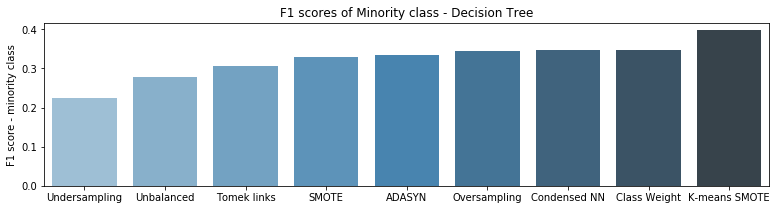

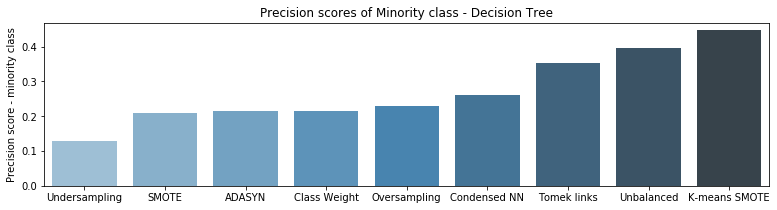

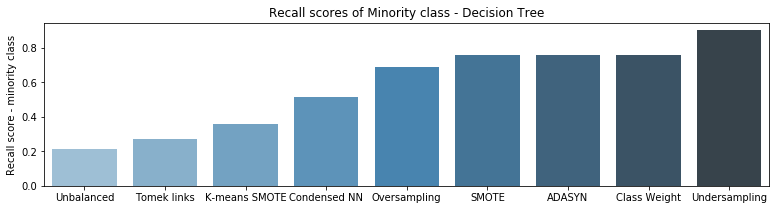

In [39]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN', 'Class Weight']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - Decision Tree')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - Decision Tree')
plt.xlabel(None)

In [41]:
roc_curves

{'unbalanced': 0.7805127573030939,
 'undersampling': 0.836404535929989,
 'condensed NN': 0.8223037100949093,
 'Tomek links': 0.8289720202144708,
 'oversampling': 0.7856711450758042,
 'SMOTE': 0.8403056822383829,
 'K-means SMOTE': 0.804603722420806,
 'ADASYN': 0.8500308147417724}

### d.3) Compare results

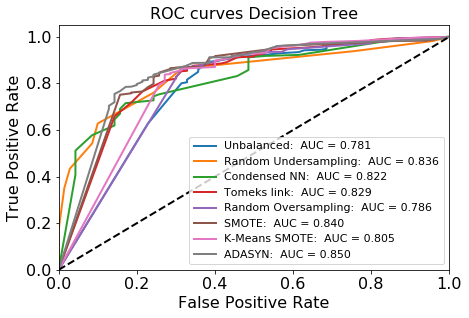

In [40]:
# plot roc curves
plt.figure(figsize=(7,4.5))

plt.plot(fpr_tpr[0][0], fpr_tpr[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves['unbalanced'])
plt.plot(fpr_tpr[1][0], fpr_tpr[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves['undersampling'])
plt.plot(fpr_tpr[2][0], fpr_tpr[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves['condensed NN'])
plt.plot(fpr_tpr[3][0], fpr_tpr[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves['Tomek links'])
plt.plot(fpr_tpr[4][0], fpr_tpr[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves['oversampling'])
plt.plot(fpr_tpr[5][0], fpr_tpr[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=2, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=2, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])


plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves Decision Tree', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## d) KNN

In [42]:
data =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]


scaler.fit(X)
X_unb_s = scaler.transform(X)
X_test_unb_s = scaler.transform(X_test)

scaler.fit(X_under)
X_under_s = scaler.transform(X_under)
X_test_under_s = scaler.transform(X_test)

scaler.fit(X_cnn)
X_cnn_s = scaler.transform(X_cnn)
X_test_cnn_s = scaler.transform(X_test)

scaler.fit(X_tomek)
X__tomek_s = scaler.transform(X_tomek)
X_test_tomek_s = scaler.transform(X_test)


scaler.fit(X_over)
X_over_s = scaler.transform(X_over)
X_test_over_s = scaler.transform(X_test)

scaler.fit(X_smote)
X_smote_s = scaler.transform(X_smote)
X_test_smote_s = scaler.transform(X_test)

scaler.fit(X_ksmote)
X_ksmote_s = scaler.transform(X_ksmote)
X_test_ksmote_s = scaler.transform(X_test)

scaler.fit(X_adasyn)
X_ada_s = scaler.transform(X_adasyn)
X_test_ada_s = scaler.transform(X_test)

### Random Search 

In [65]:
data =[(X_unb_s,y),(X_under_s,y_under),(X_cnn_s,y_cnn),(X__tomek_s, y_tomek),(X_over_s,y_over),
       (X_smote_s,y_smote),(X_ksmote_s,y_ksmote),(X_ada_s,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"weights":["distance", "uniform"],
         "n_neighbors":[x for x in range(3,25)],
         "metric": ["euclidean", "manhattan", "minkowski"],
         }

for model, title in zip(data,titles):
    knn = KNeighborsClassifier()
    clf = RandomizedSearchCV(estimator=knn, param_distributions=params, cv=5, n_iter=150, random_state=42,
                             verbose=True, return_train_score=True,n_jobs=-1 )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******unbalanced*******
{'weights': 'distance', 'n_neighbors': 13, 'metric': 'manhattan'}
accuracy validation: 0.9494062061039459
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******undersampling*******
{'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan'}
accuracy validation: 0.7682692307692307
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******condensed NN*******
{'weights': 'distance', 'n_neighbors': 10, 'metric': 'manhattan'}
accuracy validation: 0.8037664783427495
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:   57.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******Tomek links*******
{'weights': 'distance', 'n_neighbors': 11, 'metric': 'manhattan'}
accuracy validation: 0.9493354687883444
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******oversampling*******
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
accuracy validation: 0.9646809878578232
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******SMOTE*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
accuracy validation: 0.9345416802748192
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


*******K-means SMOTE*******
{'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan'}
accuracy validation: 0.9578766451101975
Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min


*******ADASYN*******
{'weights': 'distance', 'n_neighbors': 4, 'metric': 'manhattan'}
accuracy validation: 0.9283506746843135


[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  2.4min finished


### Retrain Models: Unbalanced vs Balanced

In [46]:
data_training =[(X_norm,y),(X_norm_under,y_norm_under),(X_norm_cnn_, y_norm_cnn),(X_norm_tomek, y_norm_tomek),
                (X_norm_over,y_norm_over),(X_norm_smote,y_norm_smote),(X_norm_ksmote,y_norm_ksmote),
                (X_norm_adasyn,y_norm_adasyn)]

test_data = [X_test_unb_s, X_test_under_s, X_test_cnn_s, X_test_tomek_s,
             X_test_over_s, X_test_smote_s, X_test_ksmote_s, X_test_ada_s]

models ={
    
    'unbalanced':KNeighborsClassifier(n_neighbors = 6, weights='distance', metric='manhattan'),
   
    "undesampling":KNeighborsClassifier(n_neighbors = 7, weights='uniform', metric='manhattan'),
    
    "condensed NN":KNeighborsClassifier(n_neighbors = 10, weights='distance', metric='manhattan'),
    
    "Tomek links":KNeighborsClassifier(n_neighbors = 11, weights='distance', metric='manhattan'),
    
    "oversampling":KNeighborsClassifier(n_neighbors = 3, weights='distance', metric='manhattan'),
    
    "SMOTE":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='manhattan'),
    
    "k-means SMOTE":KNeighborsClassifier(n_neighbors = 5, weights='distance', metric='manhattan'),
    
    "ADASYN":KNeighborsClassifier(n_neighbors = 4, weights='distance', metric='manhattan')
    
}

roc_curves_knn ={}
fpr_tpr_knn = []
f1_scores_minc = []
recall_minc = []
precision_minc =[]


for model, data, test, title in zip(models, data_training, test_data, titles):
    knn = models[model]
    knn.fit(data[0],data[1])
    y_pred = knn.predict(test)
    # computes roc curve for each classifier
    y_score = knn.predict_proba(test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc_knn = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    roc_curves_knn[title] = roc_auc_knn
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    fpr_tpr_knn.append((fpr,tpr))
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])   
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.9446704637917006
F1-score [0.35849057 0.97108844]

              precision    recall  f1-score   support

           0       0.53      0.27      0.36        70
           1       0.96      0.99      0.97      1159

    accuracy                           0.94      1229
   macro avg       0.74      0.63      0.66      1229
weighted avg       0.93      0.94      0.94      1229

*** undersampling classification ***
Accuracy 0.9023596419853539
F1-score [0.45945946 0.94633274]

              precision    recall  f1-score   support

           0       0.34      0.73      0.46        70
           1       0.98      0.91      0.95      1159

    accuracy                           0.90      1229
   macro avg       0.66      0.82      0.70      1229
weighted avg       0.95      0.90      0.92      1229

*** condensed NN classification ***
Accuracy 0.9495524816924329
F1-score [0.40384615 0.97366185]

              precision    recall  f1-score   support

The highest f1 score is provided by undersampling (0.46), even though also CNN and Tomek's Link reported high performances (0.40 and 0.38 respectively)
In terms of **recall of the minority class (Jazz)**, the best balancing technique is still undersampling, which boosts the recall from 0.27 to 0.73. Although the precision decreases from 0.53 to 0.34, we observe that this didn't affect the ability of the classifier of recognizing Rock songs with high precision and recall (for these the precision increased of +0.07 while the recall decreased down from 0.99 to 0.91). 
The approach that yeilded the highest f1 score is SMOTE, which provided a score of 0.40 (+0.22 compared to the unbalanced one). <br>
If we analyze the overall performances, we find out that the Condensed NN provides the best balanced results for precision, recall and f1 score. <br>


Text(0.5, 0, '')

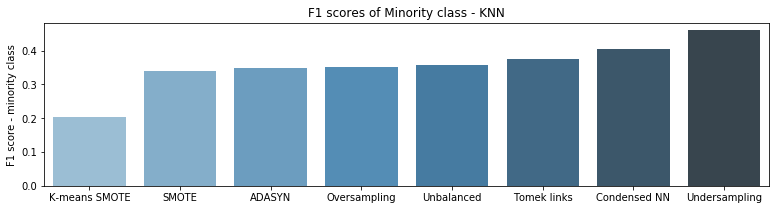

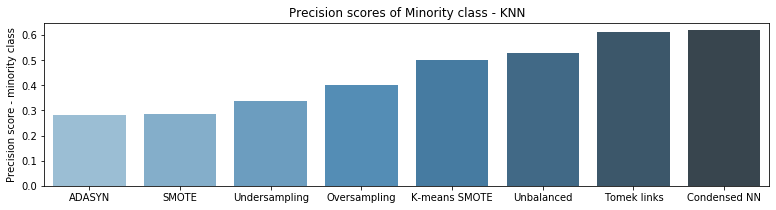

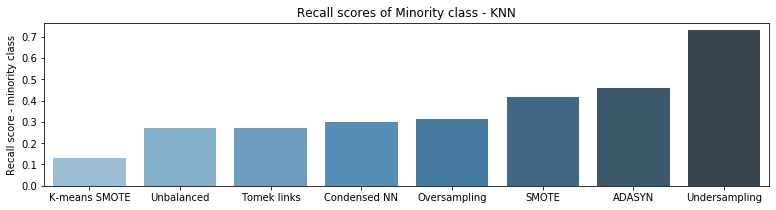

In [47]:
# plot F1 scores for minority class
df = pd.DataFrame()
df['f1'] = f1_scores_minc
df['precision'] = precision_minc
df['recall'] = recall_minc
df['models'] = ['Unbalanced','Undersampling','Condensed NN','Tomek links','Oversampling','SMOTE','K-means SMOTE',
                'ADASYN']


plt.figure(figsize=(13,3))
sns.barplot(x="models", y="f1", data=df.sort_values(by='f1'), palette="Blues_d")
plt.ylabel('F1 score - minority class')
plt.title('F1 scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="precision", data=df.sort_values(by='precision'), palette="Blues_d")
plt.ylabel('Precision score - minority class')
plt.title('Precision scores of Minority class - KNN')
plt.xlabel(None)

plt.figure(figsize=(13,3))
sns.barplot(x="models", y="recall", data=df.sort_values(by='recall'), palette="Blues_d")
plt.ylabel('Recall score - minority class')
plt.title('Recall scores of Minority class - KNN')
plt.xlabel(None)

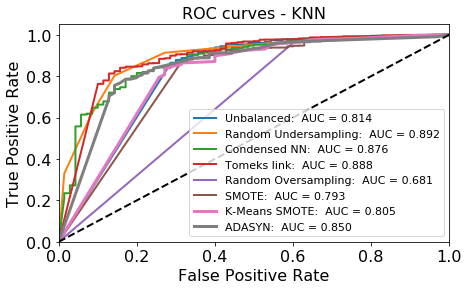

In [48]:
# plot roc curves
plt.figure(figsize=(7,4))

plt.plot(fpr_tpr_knn[0][0], fpr_tpr_knn[0][1], lw=2, label='Unbalanced:  AUC = %.3f' % roc_curves_knn['unbalanced'])
plt.plot(fpr_tpr_knn[1][0], fpr_tpr_knn[1][1], lw=2, label='Random Undersampling:  AUC = %.3f' % roc_curves_knn['undersampling'])
plt.plot(fpr_tpr_knn[2][0], fpr_tpr_knn[2][1], lw=2, label='Condensed NN:  AUC = %.3f' % roc_curves_knn['condensed NN'])
plt.plot(fpr_tpr_knn[3][0], fpr_tpr_knn[3][1], lw=2, label='Tomeks link:  AUC = %.3f' % roc_curves_knn['Tomek links'])
plt.plot(fpr_tpr_knn[4][0], fpr_tpr_knn[4][1], lw=2, label='Random Oversampling:  AUC = %.3f' % roc_curves_knn['oversampling'])
plt.plot(fpr_tpr_knn[5][0], fpr_tpr_knn[5][1], lw=2, label='SMOTE:  AUC = %.3f' % roc_curves_knn['SMOTE'])
plt.plot(fpr_tpr[6][0], fpr_tpr[6][1], lw=3, label='K-Means SMOTE:  AUC = %.3f' % roc_curves['K-means SMOTE'])
plt.plot(fpr_tpr[7][0], fpr_tpr[7][1], lw=3, label='ADASYN:  AUC = %.3f' % roc_curves['ADASYN'])



plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curves - KNN', fontsize=16)
plt.legend(loc="lower right", fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()